In [1]:
import data_loader_simple as dl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import dowhy
from dowhy import CausalModel
import pandas as pd
from sklearn.model_selection import train_test_split
from tableone import TableOne
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

In [2]:
random_seed= 42

In [3]:

df= dl.load_data()
df.head()

,year,school_id,student_id,mother_educ,father_educ,gender,computer,internet,math,read,...,country_SVK,country_SVN,country_SWE,country_TAP,country_THA,country_TUR,country_UKR,country_URY,country_USA,country_VNM
0,2018,800002,800251,4,4,1,1,1,490.187,375.984,...,0,0,0,0,0,0,0,0,0,0
1,2018,800002,800402,2,2,1,1,1,462.464,434.352,...,0,0,0,0,0,0,0,0,0,0
2,2018,800002,801902,2,2,0,0,0,406.949,359.191,...,0,0,0,0,0,0,0,0,0,0
3,2018,800002,803546,2,2,1,0,0,482.501,425.131,...,0,0,0,0,0,0,0,0,0,0
4,2018,800002,804776,2,4,1,1,1,459.804,306.028,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#save df as csv
# df.to_csv('cleand_df2018.csv', index=False)

In [5]:
treatment = "computer"
outcome = "achievement"

country_cols = [col for col in df.columns if col.startswith("country_")]




confounders = [
    'escs', 'mother_educ', 'father_educ', 'desk', 'room', 'book', 'gender'
] + country_cols



In [6]:
X=df[confounders]
y=df[outcome]
T=df[treatment]


In [7]:
X_train, X_val, T_train, T_val, y_train, y_val = train_test_split(X, T, y, test_size=0.3, random_state=random_seed)

In [8]:

def train_propensity_model(model, X_train, T_train):
    """
    Return a fitted propensity model on your training data
    :param model:
    :param X_train:
    :param T_train:
    :return:
    """
    return model.fit(X_train, T_train)

def eval_propensity_model(fitted_model, X_val, T_val,model_name="Propensity Model"):
    """

    :param fitted_model:
    :param X_val:
    :param T_val:
    :return:
    """


    # Get the predicted probabilities
    y_pred = fitted_model.predict_proba(X_val)[:, 1]

    # Calculate the Brier score
    brier_score = brier_score_loss(T_val, y_pred)
    print('' + model_name + ' evaluation:')
    # Print the Brier score
    print(f'Brier score: {brier_score}')

    # Plot the calibration curve
    prob_true, prob_pred = calibration_curve(T_val, y_pred, n_bins=10)

    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration curve')
    plt.legend()
    plt.show()


Logistic Regression CV:  Brier=0.0981
Random Forest:  Brier=0.1121
Extra Trees:  Brier=0.1395
XGBoost:  Brier=0.0985
Gradient Boosting:  Brier=0.0982
CatBoost:  Brier=0.0991

All results:
                            Brier
Logistic Regression CV  0.098097
Random Forest           0.112116
Extra Trees             0.139472
XGBoost                 0.098538
Gradient Boosting       0.098243
CatBoost                0.099105
Best model by Brier: Logistic Regression CV (0.0981)


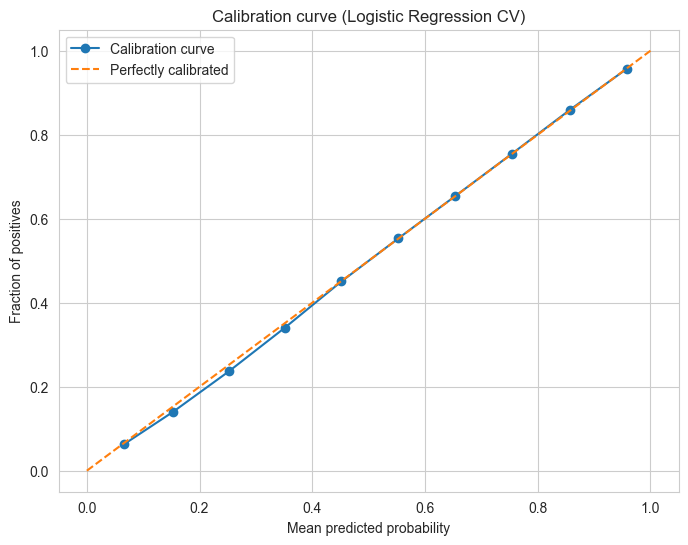

In [9]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_auc_score, brier_score_loss, accuracy_score,
    log_loss, f1_score, precision_score, recall_score
)
from sklearn.calibration import calibration_curve
import pandas as pd
import joblib
import matplotlib.pyplot as plt

models = {
    "Logistic Regression CV": LogisticRegressionCV(cv=5, max_iter=1000, random_state=random_seed),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=random_seed),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=random_seed),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, eval_metric='logloss', random_state=random_seed),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=random_seed),
    "CatBoost": CatBoostClassifier(iterations=100, depth=3, learning_rate=0.1, verbose=0, random_state=random_seed),

}

results = {}

for name, model in models.items():
    model.fit(X_train, T_train)
    probas = model.predict_proba(X_val)[:, 1]
    preds = model.predict(X_val)
    auc = roc_auc_score(T_val, probas)
    brier = brier_score_loss(T_val, probas)
    acc = accuracy_score(T_val, preds)
    ll = log_loss(T_val, probas)
    f1 = f1_score(T_val, preds)
    precision = precision_score(T_val, preds)
    recall = recall_score(T_val, preds)
    results[name] = {
        'Brier': brier
        }
    print(f"{name}:  Brier={brier:.4f}")

df_results = pd.DataFrame(results).T
print("\nAll results:\n", df_results)


best_brier_model = df_results['Brier'].idxmin()



print(f"Best model by Brier: {best_brier_model} ({df_results.loc[best_brier_model, 'Brier']:.4f})")

# Save the best model
best_model = models[best_brier_model]
# Calibration curve for the best model
probas = best_model.predict_proba(X_val)[:, 1]

prob_true, prob_pred = calibration_curve(T_val, probas, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title(f'Calibration curve ({best_brier_model})')
plt.legend()
plt.show()


In [10]:
def check_overlap(propensity_model, X_train, T_train,):
    """
    Show histograms of the propensity on the T=0 and the T=1 group

    :param propensity_model:
    :param X_train:
    :param T_train:
    :return:
    """
    # Get the predicted probabilities
    y_pred = propensity_model.predict_proba(X_train)[:, 1]

    # Create histograms for T=0 and T=1
    plt.figure(figsize=(10, 6))

    sns.histplot(y_pred[T_train == 1], color='red', label='Treated (Has Computer)', bins=30, stat="density", alpha=0.6)
    sns.histplot(y_pred[T_train == 0], color='blue', label='Control (No Computer)', bins=30, stat="density", alpha=0.6)

    plt.xlabel('Predicted Probability of Treatment')
    plt.ylabel('Density')
    plt.title('Overlap Check: Predicted Probabilities for T=0 and T=1')


    plt.legend()
    plt.show()


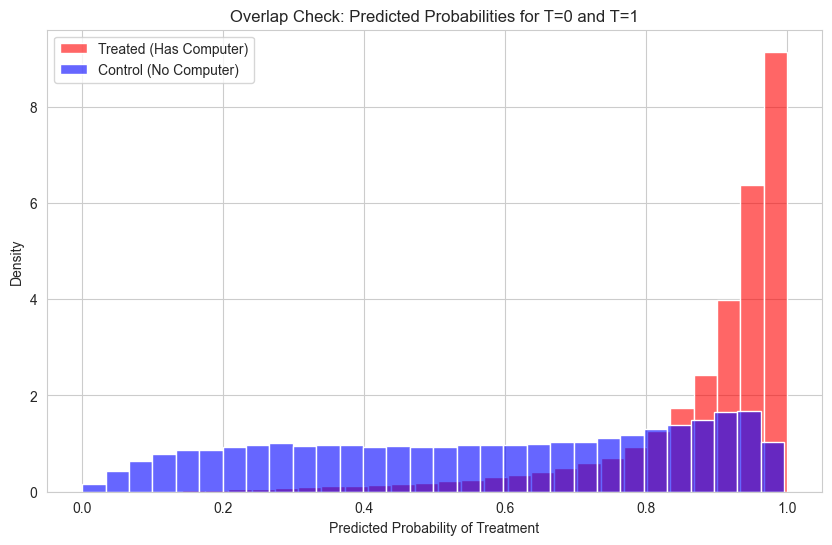

In [11]:
check_overlap(best_model, X_train, T_train)

In [17]:
def trim_by_propensity(X, y, T, propensity_scores, lower=0.05, upper=0.95):
    mask = (propensity_scores >= lower) & (propensity_scores <= upper)
    X_trim = X[mask]
    y_trim = y[mask]
    T_trim = T[mask]
    propensity_scores_trim = propensity_scores[mask]
    print(f"Trimmed to {mask.sum()} samples (from {len(mask)}) in [{lower}, {upper}] region.")
    return X_trim, y_trim, T_trim, propensity_scores_trim

propensity_scores = best_model.predict_proba(X)[:, 1]

# Trim the data
X_trim, y_trim, T_trim, propensity_scores_trim = trim_by_propensity(
    X, y, T, propensity_scores, lower=0.05, upper=0.95
)

Trimmed to 391652 samples (from 612004) in [0.05, 0.95] region.


In [18]:
X_train, X_val, T_train, T_val, y_train, y_val = train_test_split(X_trim, T_trim, y_trim, test_size=0.3, random_state=random_seed)

In [14]:
#re train the best model on the trimmed data
best_model = train_propensity_model(best_model, X_train, T_train)


In [19]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import (
    mean_squared_error
)
from sklearn.base import clone
import joblib

def train_t_learner(model, X_train, y_train):
    return model.fit(X_train, y_train)

from tqdm.auto import tqdm

def t_learner_model_selection(models, X_train, y_train, X_val, y_val):
    metrics = {
        "MSE": lambda y_true, y_pred: mean_squared_error(y_true, y_pred),
    }
    results = {name: {} for name in [m.__class__.__name__ for m in models]}
    best_models = {}

    for metric_name, metric_func in tqdm(metrics.items(), desc="Metrics"):
        best_score = np.inf if metric_name in ["MSE"] else -np.inf
        best_model = None

        for model in tqdm(models, desc=f"Models for {metric_name}", leave=False):
            fitted_model = train_t_learner(clone(model), X_train, y_train)
            y_pred = fitted_model.predict(X_val)
            score = metric_func(y_val, y_pred)
            results[model.__class__.__name__][metric_name] = score

            is_better = (score < best_score) if metric_name in ["MSE"] else (score > best_score)
            if is_better:
                best_score = score
                best_model = fitted_model

        best_models[metric_name] = best_model
        print(f'Best model for {metric_name}: {best_model.__class__.__name__} with score {best_score:.4f}')

    # Display results table
    df_results = pd.DataFrame(results).T
    print("All validation scores:")
    print(df_results)

    for metric_name in metrics:
        print(f"Best model by {metric_name}: {best_models[metric_name].__class__.__name__} (Score: {df_results[metric_name][best_models[metric_name].__class__.__name__]:.4f})")

    # Save best model by MSE
    joblib.dump(best_models["MSE"], "best_t_learner_model_MSE.pkl")
    print(f"\nSaved best T-learner model (by MSE): {best_models['MSE'].__class__.__name__}")

    return best_models


models = [
    LinearRegression(),
    Ridge(alpha=1.0),
    Lasso(alpha=0.1),
    RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0),
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0),
    XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=0),
    LGBMRegressor(n_estimators=100, max_depth=3, random_state=0),

]

# For treated
X_train_treated = X_train[T_train == 1]
y_train_treated = y_train[T_train == 1]
X_val_treated = X_val[T_val == 1]
y_val_treated = y_val[T_val == 1]
# For control
X_train_control = X_train[T_train == 0]
y_train_control = y_train[T_train == 0]
X_val_control = X_val[T_val == 0]
y_val_control = y_val[T_val == 0]
print(" Selecting model for T=1")
best_models_treated = t_learner_model_selection(models, X_train_treated, y_train_treated, X_val_treated, y_val_treated)

print(" Selecting model for T=0 ")
best_models_control = t_learner_model_selection(models, X_train_control, y_train_control, X_val_control, y_val_control)


 Selecting model for T=1


Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Models for RMSE:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 205135, number of used features: 86
[LightGBM] [Info] Start training from score 445.630660
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Models for RMSE:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 69021, number of used features: 86
[LightGBM] [Info] Start training from score 399.299181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

doubly robust

In [20]:


def calculate_dr_ate(y, T, propensity_scores, mu0_pred, mu1_pred):
    """
    Doubly Robust ATE Estimation.

    Args:
        y:      Observed outcome
        T:      Treatment indicator (
        propensity_scores:  estimated propensity
        mu0_pred:  Predicted outcome  untreated
        mu1_pred:  Predicted outcome  treated

    Returns:
        dr_ate:  Estimated ATE
    """

    # eps = 1e-6
    # propensity_scores = np.clip(propensity_scores, eps, 1-eps)

    # Doubly Robust estimate:
    dr_scores = (mu1_pred - mu0_pred) \
        + T * (y - mu1_pred) / propensity_scores \
        - (1 - T) * (y - mu0_pred) / (1 - propensity_scores)

    dr_ate = np.mean(dr_scores)
    print(f"Estimated ATE (Doubly Robust): {dr_ate:.4f}")
    return dr_ate

mu1_pred = best_models_treated['MSE'].predict(X_trim)
mu0_pred = best_models_control['MSE'].predict(X_trim)

dr_ate = calculate_dr_ate(y_trim, T_trim, propensity_scores_trim, mu0_pred, mu1_pred)


Estimated ATE (Doubly Robust): 19.3054


In [21]:

from sklearn.base import clone
from tqdm.auto import tqdm

def dr_confidence_intervals(
    X, y, T,
    propensity_model, model_treated, model_control,
    n_iterations=1000, alpha=0.05, random_seed=random_seed, verbose=True
):
    """
    Bootstrap 95% confidence interval for Doubly Robust ATE.

    Args:
        X: Features  already trimmed
        y: Outcome
        T: Treatment
        propensity_model: fitted propensity score model
        model_treated: fitted outcome model for T=1
        model_control: fitted outcome model for T=0
        n_iterations: number of bootstrap samples
        alpha: significance level
        random_seed: for reproducibility
        verbose: whether to print the CI

    Returns:
        (lower, upper): bounds of the confidence interval
    """
    np.random.seed(random_seed)
    ate_estimates = []
    eps = 1e-6

    for _ in tqdm(range(n_iterations), desc="DR Bootstrap"):
        # Sample with replacement
        indices = np.random.choice(X.index, size=len(X), replace=True)
        X_boot = X.loc[indices]
        y_boot = y.loc[indices]
        T_boot = T.loc[indices]

        # Estimate propensity
        # p_scores = np.clip(propensity_model.predict_proba(X_boot)[:, 1], eps, 1-eps)
        p_scores=propensity_model.predict_proba(X_boot)[:, 1]
        # Predict outcomes as if all treated / control
        mu1_pred = model_treated.predict(X_boot)
        mu0_pred = model_control.predict(X_boot)

        # DR estimate
        dr_scores = (mu1_pred - mu0_pred) \
            + T_boot * (y_boot - mu1_pred) / p_scores \
            - (1 - T_boot) * (y_boot - mu0_pred) / (1 - p_scores)
        dr_ate = np.mean(dr_scores)
        ate_estimates.append(dr_ate)

    lower = np.percentile(ate_estimates, 100 * alpha / 2)
    upper = np.percentile(ate_estimates, 100 * (1 - alpha / 2))
    if verbose:
        print(f"95% Confidence Interval for ATE (Doubly Robust): [{lower:.4f}, {upper:.4f}]")
    return lower, upper

dr_ci = dr_confidence_intervals(
    X_trim, y_trim, T_trim,
    propensity_model=best_model,
    model_treated=best_models_treated['MSE'],
    model_control=best_models_control['MSE'],
    alpha=0.05,
    random_seed=random_seed
)


DR Bootstrap:   0%|          | 0/1000 [00:00<?, ?it/s]

95% Confidence Interval for ATE (Doubly Robust): [18.5820, 20.0026]
